# 1. Imports

In [6]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

# 2. Агенты

## copy_opponent

- Копируем предыдущий шаг опонента

In [ ]:
%%writefile copy_opponent_agent.py

import random
from pprint import pformat

def copy_opponent_agent(observation, configuration):
    if observation.step > 0:
        result = observation.lastOpponentAction
    else:
        result = random.randrange(0, configuration.signs)
    print(
        f"\nstep: {observation.step}"
        f" observation:"
        f" {pformat(observation)}"
        f" play: {result}"
    )
    return result


Overwriting copy_opponent.py


## random

- Выбираем случайно

In [82]:
%%writefile random_agent.py

import random
from pprint import pformat

def random_agent(observation, configuration):
    result = random.randrange(0, configuration.signs)
    return result

Overwriting random_agent.py


## up

- Постоянно выбираем сильнее предыдущего шага опонента

In [95]:
%%writefile up_agent.py

import random
from pprint import pformat

def up_agent(observation, configuration):
    if observation.step > 0:
    # if getattr(observation, 'lastOpponentAction') and not (observation.lastOpponentAction is None):
        result = (observation.lastOpponentAction + 1) % configuration.signs
    else:
        result = random.randrange(0, configuration.signs)
    print(f"step: {observation.step}, {observation}, result: {result}")
    return result


Overwriting up_agent.py


## down

- Постоянно выбираем слабее предыдущего шага опонента

In [94]:
%%writefile down_agent.py

import random
from pprint import pformat

def down_agent(observation, configuration):
    if observation.step > 0:
        result = (observation.lastOpponentAction - 1) % configuration.signs
    else:
        result = random.randrange(0, configuration.signs)
    return result


Overwriting down_agent.py


## up_or_copy

- 50/50 выбираем, либо сильнее, либо копируем оппонента

In [103]:
%%writefile up_or_copy_agent.py

import random

def up_or_copy_agent(observation, configuration):
    shift = random.choice([0, 1])
    if 'lastOpponentAction' in observation and not (
        observation.lastOpponentAction is None
    ):
        result = (observation.lastOpponentAction + shift) % configuration.signs
    else:
        result = random.randrange(0, configuration.signs)
    return result

Overwriting up_or_copy_agent.py


## down_or_copy

- 50/50 выбираем, либо слабее, либо копируем оппонента

In [104]:
%%writefile down_or_copy_agent.py

import random

def down_or_copy_agent(observation, configuration):
    shift = random.choice([0, 1])
    if 'lastOpponentAction' in observation and not (
        observation.lastOpponentAction is None
    ):
        result = (observation.lastOpponentAction - shift) % configuration.signs
    else:
        result = random.randrange(0, configuration.signs)
    return result

Writing down_or_copy_agent.py


## statistical_or_random

- На первом шаге выбираем случайно
- В 10% случаев будем выбирать случайно
- Иначе выбираем по статистике

In [129]:
%%writefile statistical_or_random_agent.py

import random

def statistical_or_random_agent(observation, configuration):
    global action_histogram
    # На первом шаге выбираем случайно
    if observation.step == 0:
        action_histogram = {}
        return random.randrange(0, configuration.signs)
    
    # В 10% случаев будем выбирать случайно
    if not random.randint(0, 10):  
        return random.randrange(0, configuration.signs)
    
    # Иначе выбираем по статистике
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical_or_random_agent.py


# 3. Турнир


In [130]:
# Агенты - участники турнира
agents: list = [
    "paper",
    "scissors",
    "rock",
    "reactionary",
    "counter_reactionary",
    "statistical",
    "copy_opponent", 
    "random_agent.py", 
    "up_agent.py",
    "down_agent.py",
    "up_or_copy_agent.py",
    "down_or_copy_agent.py",
    "statistical_or_random_agent.py",
]
# Удаляем .py из имен стратегий
agent_names: list = [
    i.rsplit('_', maxsplit=1)[0] if i.endswith('_agent.py') else i
    for i in agents
]
# print(agent_names)

# Имена стратегий будем использовать для индекса и колонок
n: int = 100
tnt: pd.DataFrame = pd.DataFrame(
    index=agent_names, columns=agent_names, dtype=np.int16,
)
# print(tnt.describe())

for i in range(len(agents)):
    for j in range(len(agents)):
        # Пропускаем уже заполненные ячейки
        if not np.isnan(tnt.iloc[i, j]):
            # print(f"{i}, {j}: {tnt.iloc[i, j]}, {type(tnt.iloc[i, j])}")
            continue
        
        # Запускаем турнир для агентов i и j
        result = evaluate(
            "rps",                              # environment to use
            agents=(agents[i], agents[j]),      # agents to evaluate
            configuration={"episodeSteps": n},  # number of episodes 
            # debug=True,
        )
        tnt.iloc[i, j] = result[0][0]           # Put evaluation result for i agent
        tnt.iloc[j, i] = result[0][1]


In [131]:
# print(tnt.isna())
# print(tnt.info())
# print(tnt.describe())
tnt

,paper,scissors,rock,reactionary,counter_reactionary,statistical,copy_opponent,random,up,down,up_or_copy,down_or_copy,statistical_or_random
paper,0.0,-99.0,99.0,-98.0,-48.0,-97.0,0.0,0.0,-97.0,97.0,-53.0,49.0,-83.0
scissors,99.0,0.0,-99.0,-98.0,-48.0,-99.0,0.0,0.0,-99.0,99.0,-49.0,45.0,-90.0
rock,-99.0,99.0,0.0,-98.0,-49.0,-98.0,0.0,0.0,-98.0,97.0,-56.0,45.0,-90.0
reactionary,98.0,98.0,98.0,0.0,0.0,49.0,49.0,0.0,0.0,99.0,0.0,0.0,49.0
counter_reactionary,48.0,48.0,49.0,0.0,0.0,95.0,-96.0,0.0,99.0,-48.0,0.0,-24.0,76.0
statistical,97.0,99.0,98.0,-49.0,-95.0,0.0,22.0,0.0,-57.0,99.0,-26.0,43.0,0.0
copy_opponent,0.0,0.0,0.0,-49.0,96.0,-22.0,0.0,0.0,99.0,49.0,0.0,0.0,0.0
random,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
up,97.0,99.0,98.0,0.0,-99.0,57.0,-99.0,0.0,0.0,-49.0,0.0,0.0,49.0
down,-97.0,-99.0,-97.0,-99.0,48.0,-99.0,-49.0,0.0,49.0,0.0,0.0,0.0,-90.0


# 4. Анализ

In [132]:
# Суммируем баллы по стратегии
tnt['sum'] = tnt[agent_names].sum(axis=1)
tnt.sort_values(by=['sum'], ascending=False, inplace=True)

print(f"Победитель: {tnt['sum'].idxmax()}")
print(f"\nРезультаты лучших топ 5:\n{tnt.head(5)['sum']}")

Победитель: reactionary

Результаты лучших топ 5:
reactionary              540.0
counter_reactionary      247.0
statistical              231.0
up_or_copy               213.0
statistical_or_random    200.0
Name: sum, dtype: float64


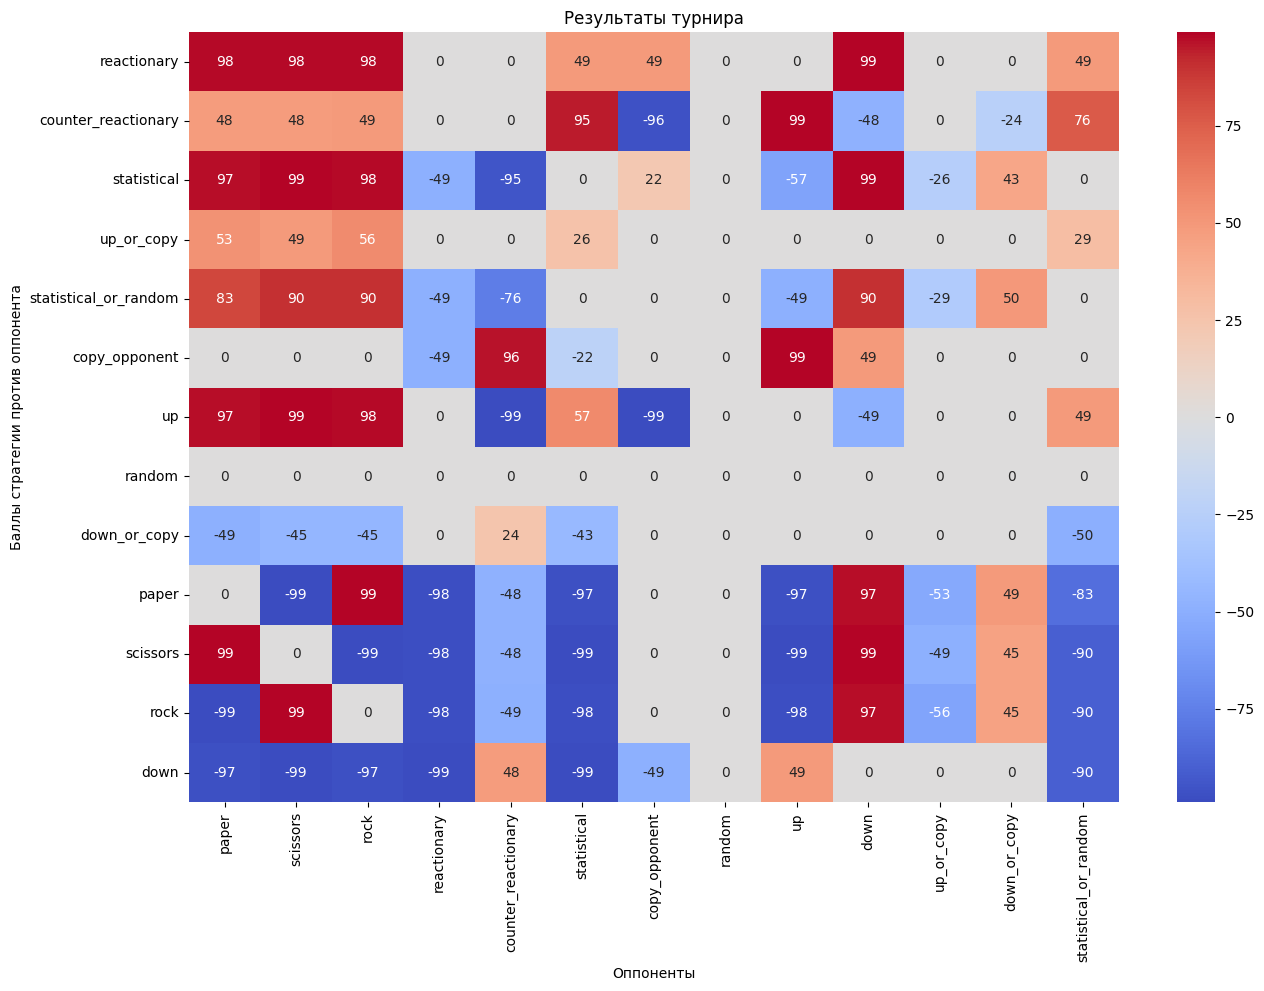

In [133]:
plt.figure(figsize=(15, 10))
df = tnt[agent_names]
sns.heatmap(df, annot=True, cmap='coolwarm', center=0)
plt.xlabel("Оппоненты")
plt.ylabel("Баллы стратегии против оппонента")
plt.title('Результаты турнира')
plt.show()


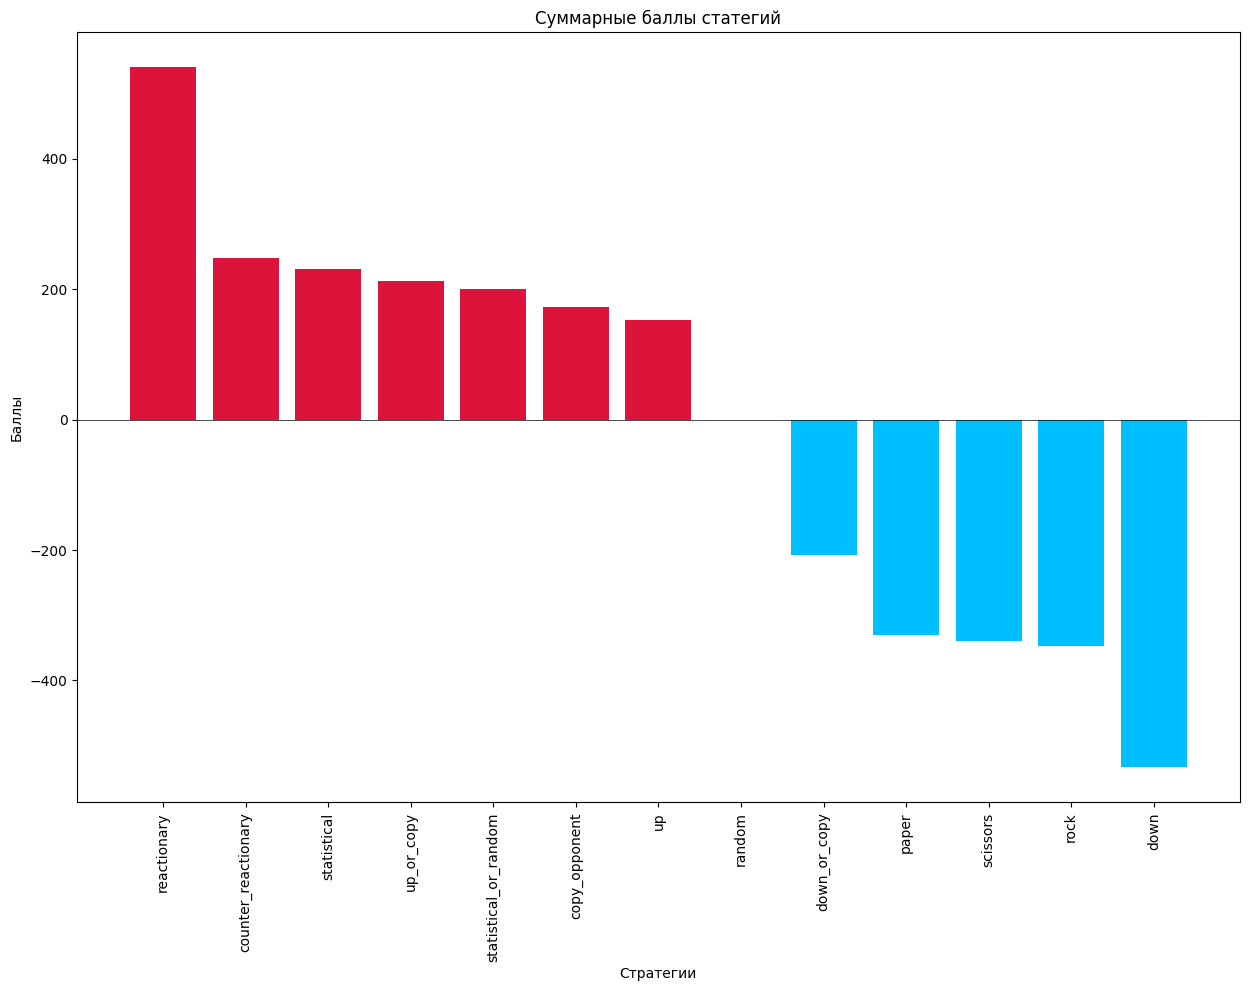

In [134]:
plt.figure(figsize=(15, 10))

df = tnt
plt.bar(
    df.index, 
    df['sum'],
    color=np.where(df['sum'] < 0, 'deepskyblue', 'crimson'),
)
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel("Стратегии")
plt.ylabel("Баллы")
plt.title("Суммарные баллы статегий")
plt.show()